# Classifying Fashion MNIST with Keras

In [84]:
import random, os, glob, tarfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow imports
import tensorflow as tf
print(f"Using Tensorflow: {tf.__version__}")
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline
plt.style.use('seaborn')
sns.set(style='darkgrid', font_scale=1.2)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Using Tensorflow: 2.3.1


In [85]:
DATASET_URL = 'https://datashare.is.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz?sequence=4&isAllowed=y'
DATA_FOLDER = './data'
DATA_FILE = 'cinic10'
DATA_FILE_EXT = 'tar.gz'
DATA_FILE_NAME = '.'.join([DATA_FILE, DATA_FILE_EXT])
DATA_FILE_PATH = os.path.join(DATA_FOLDER, DATA_FILE_NAME)
TAR_EXTRACT_LOC = os.path.join(os.path.expanduser("~"),'.keras', 'datasets', DATA_FILE)
print(f"Data file name: {DATA_FILE_NAME} - Data file path: {DATA_FILE_PATH} - Tar extract loc: {TAR_EXTRACT_LOC}")

Data file name: cinic10.tar.gz - Data file path: ./data\cinic10.tar.gz - Tar extract loc: C:\Users\manis\.keras\datasets\cinic10


In [86]:
# following cell prevents error -> [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: ] ....
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [87]:
def get_data():
    """ load & pre-process data """
    from tensorflow.keras.utils import get_file
    
    # download the TAR file from URL to default location only if not downloaded before
    downloaded_file_loc = os.path.join(os.path.expanduser("~"),'.keras', 'datasets', DATA_FILE_NAME)
    if not os.path.exists(downloaded_file_loc):
        _ = get_file(origin=DATASET_URL, fname=DATA_FILE_NAME, extract=False)
        print(f"File downloaded to {downloaded_file_loc}")
 
    # grab the data directory
    tar = tarfile.open(downloaded_file_loc)
    tar_extract_loc = os.path.join(os.path.expanduser("~"),'.keras', 'datasets', DATA_FILE)
    print(f"Untaring {DATA_FILE_NAME} to {tar_extract_loc}...", flush=True)
    tar.extractall(tar_extract_loc)
    print(f"Extracted {len(os.listdir(tar_extract_loc))} files")
    
get_data()

Untaring cinic10.tar.gz to C:\Users\manis\.keras\datasets\cinic10...
Extracted 6 files


In [88]:
data_wildcard = os.path.sep.join([TAR_EXTRACT_LOC, "*/*/*.png"])
image_paths = list(glob.glob(data_wildcard))
print(f"Found {len(image_paths):,} PNG images under {TAR_EXTRACT_LOC} folder")

Found 270,000 PNG images under C:\Users\manis\.keras\datasets\cinic10 folder


In [89]:
def display_sample(image_paths, num_count=50, num_rows=5, num_cols=10, fig_size=(16,8)):
    
    assert (num_count == (num_rows * num_cols)), 'num_rows * num_cols != num_count - must match!'
    
    np.random.seed(SEED)
    random_50_indexes = np.random.randint(0, len(image_paths), num_count)
    sample_image_paths = np.array(image_paths)[random_50_indexes]

    plt.figure(figsize=fig_size)
    for i, image_path in enumerate(sample_image_paths):
        plt.subplot(5, 10, i+1)
        img = load_img(image_path)
        img_array = img_to_array(img)
        plt.imshow(img_array / 255, cmap='Greys')
        plt.axis('off')

    plt.show()
    plt.close()

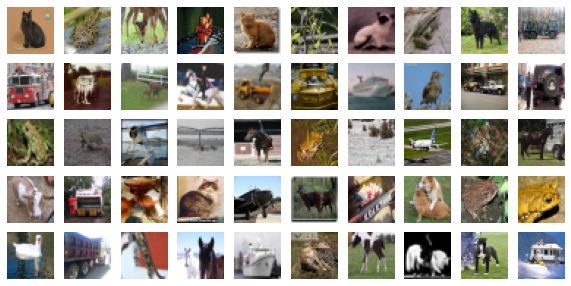

In [90]:
display_sample(image_paths, fig_size=(10,5))

### Building Models
In this section we'll develop the same model using 3 options provided by `tf.keras`

In [91]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [92]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS = 32, 32, 3
NUM_EPOCHS, BATCH_SIZE = 25, 32

In [93]:
# using Sequential model
sequential_model = Sequential([
    Dense(256, activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)),
    Dense(128, activation='relu'), 
    Dense(10, activation='softmax')
])

sequential_model.compile(loss='sparse_categorical_crossentropy', 
                         optimizer='adam', metrics=['accuracy'])
print(sequential_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32, 32, 256)       1024      
_________________________________________________________________
dense_22 (Dense)             (None, 32, 32, 128)       32896     
_________________________________________________________________
dense_23 (Dense)             (None, 32, 32, 10)        1290      
Total params: 35,210
Trainable params: 35,210
Non-trainable params: 0
_________________________________________________________________
None


In [94]:
input_layer = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,))
dense_1 = Dense(256, activation='relu')(input_layer)
dense_2 = Dense(128, activation='relu')(dense_1)
predictions = Dense(10, activation='softmax')(dense_2)
functional_model = Model(inputs=input_layer, outputs=predictions)
functional_model.compile(loss='sparse_categorical_crossentropy', 
                         optimizer='adam', metrics=['accuracy'])
print(functional_model.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
dense_24 (Dense)             (None, 32, 32, 256)       1024      
_________________________________________________________________
dense_25 (Dense)             (None, 32, 32, 128)       32896     
_________________________________________________________________
dense_26 (Dense)             (None, 32, 32, 10)        1290      
Total params: 35,210
Trainable params: 35,210
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
class ClassModel(Model):
    def __init__(self):
        super(ClassModel, self).__init__()
        self.dense_1 = Dense(256, activation='relu'),
        self.dense_2 = Dense(128, activation='relu'),
        self.out = Dense(256, activation='softmax')
        
    def call(self, inputs, **kwargs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        return self.out(x)
    
class_model = ClassModel()
class_model.compile(loss='sparse_categorical_crossentropy', 
                    optimizer='adam', metrics=['accuracy'])
print(class_model.summary()) 

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [96]:
models = {
    'sequential_model' : sequential_model,
    'functional_model' : functional_model,
    'class_model' : class_model
}

In [97]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(
    rescale=1./255)

test_datagen = ImageDataGenerator(
    rescale=1./255)

In [98]:
train_dir = os.path.join(TAR_EXTRACT_LOC, 'train')
val_dir = os.path.join(TAR_EXTRACT_LOC, 'valid')
test_dir = os.path.join(TAR_EXTRACT_LOC, 'test')

In [99]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(32,32),
    batch_size=BATCH_SIZE)

valid_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(32,32),
    batch_size=BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32,32),
    batch_size=BATCH_SIZE)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [100]:
for model_name, model in models.items():
    print(f"Training model {model_name}", flush=True)
    model.fit(train_generator, steps_per_epoch=100, epochs=NUM_EPOCHS,
              validation_data=valid_generator, validation_steps=50)

Training model sequential_model
Epoch 1/25


InvalidArgumentError:  Incompatible shapes: [32,32,32] vs. [32,10]
	 [[node Equal (defined at <ipython-input-100-e5ded8fb4df3>:3) ]] [Op:__inference_train_function_3511]

Function call stack:
train_function


In [ ]:
for model_name, model in model.items():
    print('Evaluating {model_name}....', flush=True)
    loss, acc = model.evaluate(train_generator)
    print(f'  Training data  -> loss: {loss:.3f} - acc: {acc:.3f}')
    loss, acc = model.evaluate(valid_generator)
    print(f'  Cross-val data -> loss: {loss:.3f} - acc: {acc:.3f}')
    loss, acc = model.evaluate(test_generator)
    print(f'  Testing data   -> loss: {loss:.3f} - acc: {acc:.3f}')